In [1]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
)
import matplotlib.pyplot as plt


In [2]:
#Loading Data and Choose Features 


df = pd.read_csv("titanic_augmented.csv")

# Minimal + common strong features
features = ["Age", "Sex", "Pclass", "Fare", "SibSp", "Parch", "Embarked"]
target = "Survived"

df = df[features + [target]].copy()
df.head()


,Age,Sex,Pclass,Fare,SibSp,Parch,Embarked,Survived
0,22.0,male,3,7.2500,1,0,S,0
1,38.0,female,1,71.2833,1,0,C,1
2,26.0,female,3,7.9250,0,0,S,1
3,35.0,female,1,53.1000,1,0,S,1
4,35.0,male,3,8.0500,0,0,S,0


In [3]:
#Train/Test Split 

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,        
    stratify=y,             
    random_state=0
)


In [4]:
#Preprocessing 

numeric_features = ["Age", "Fare", "SibSp", "Parch"]
categorical_features = ["Sex", "Pclass", "Embarked"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [12]:
#Model Training and Hyperparameter Tuning with k-fold CV


pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, random_state=0))
])

param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 50],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,               
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)
best_model = grid.best_estimator_


Best params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV AUC: 0.8607581301921071


In [13]:
#Model Evaluation (Test Set)


y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print("Test Accuracy:", test_acc)
print("Test AUC:", test_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.7937219730941704
Test AUC: 0.8279154642675268

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.84       137
           1       0.80      0.62      0.70        86

    accuracy                           0.79       223
   macro avg       0.80      0.76      0.77       223
weighted avg       0.79      0.79      0.79       223



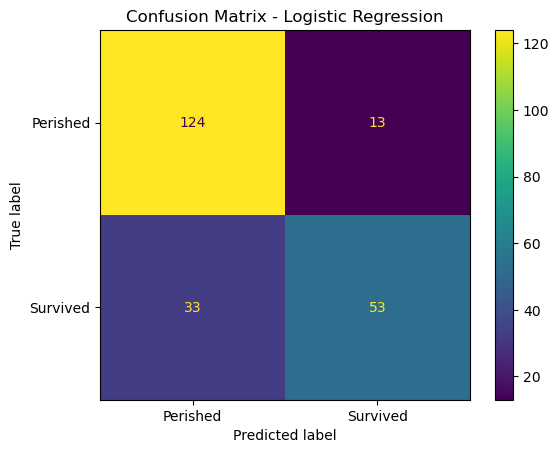

In [14]:
#Confusion Matrix

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Perished", "Survived"]
)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


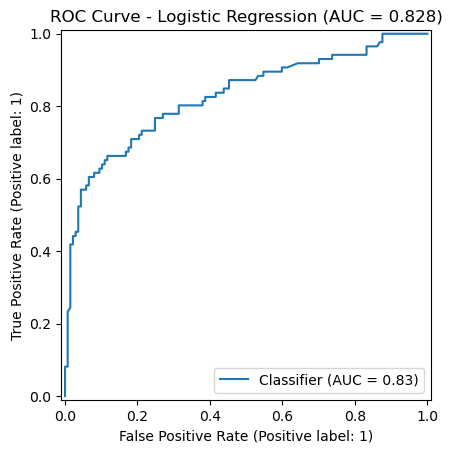

In [15]:
#ROC Curve + AUC 


RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title(f"ROC Curve - Logistic Regression (AUC = {test_auc:.3f})")
plt.show()


In [16]:
#Feature Importance - Logistic Regression Coefficients

# Get the feature names after one-hot encoding
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_names])

coefs = best_model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefs,
    "AbsCoeff": np.abs(coefs)
}).sort_values("AbsCoeff", ascending=False)

coef_df.head(15)


,Feature,Coefficient,AbsCoeff
4,Sex_female,1.085565,1.085565
5,Sex_male,-1.083377,1.083377
8,Pclass_3,-0.801760,0.801760
6,Pclass_1,0.581125,0.581125
0,Age,-0.366030,0.366030
2,SibSp,-0.284898,0.284898
1,Fare,0.269390,0.269390
7,Pclass_2,0.222824,0.222824
11,Embarked_S,-0.157300,0.157300
9,Embarked_C,0.126361,0.126361
